In [2]:
import os, sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
sys.path.append('/home/ubuntu/crypto_prediction/git/crypto_prediction_ml_dl/script')
from trino_operations import trino_operator

warnings.filterwarnings("ignore")
trino_ope = trino_operator.Operator()

In [3]:
def create_dataframe_from_hive_mart_table(
    target_schema, target_table, target_columns, target_symbol, column_prefix
):
    """Load data form Hive mart table

        Args:
            target_schema: hive schema name
            target_table: hive table name
            target_columns: column name list to load
            target_symbol: symbol name (e.g., BTC_USDT)
            column_prefix: prefix name for each column

        Returns:
            data frame
    """
    query = f"""
    select
        {target_columns}
    from 
        hive.{target_schema}.{target_table}
    where
        id = '{target_symbol}'
    order by dt
    """

    res = trino_ope.run_query(query)

    indicators_query_result = {}
    for idx, row_data in enumerate(res,1):
        indicators_query_result[int(idx)] = row_data

    target_columns_list = [
        column_prefix + column.strip() for column in target_columns.strip().split(",")
    ]

    indicators_raw_df = pd.DataFrame.from_dict(
        indicators_query_result, orient="index", columns=target_columns_list
    )

    return indicators_raw_df

In [4]:
########################
# Load BTC_USDT OHLC and indicators
########################
target_schema = "crypto_mart"
target_table = "crypto_indicator_day"
target_symbol = "BTC_USDT"
column_prefix = "btc_"
target_columns = """
    dt,
    low,
    high,
    open,
    close,
    volume
    """

btc_raw_df = create_dataframe_from_hive_mart_table(
    target_schema, target_table, target_columns, target_symbol, column_prefix
)

btc_raw_df.tail()

,btc_dt,btc_low,btc_high,btc_open,btc_close,btc_volume
1062,2023-09-28,26339.60,27290.24,26369.34,27017.99,51378024.0
1063,2023-09-29,26704.52,27224.08,27019.20,26906.87,50639060.0
1064,2023-09-30,26888.80,27086.59,26903.78,26963.34,31372394.0
1065,2023-10-01,26950.96,28023.42,26962.75,27963.19,28923746.0
1066,2023-10-02,27883.68,28034.81,27975.06,27922.50,1756101.5


In [7]:
####################################
# Create Dataset with target value
####################################

# Check if all "date" exist in the dataframe.
first_dt = str(btc_raw_df.iloc[0]['btc_dt'])
last_dt = str(btc_raw_df.iloc[-1]['btc_dt'])
desired_date_range = pd.date_range(start=first_dt, end=last_dt, freq='D')
all_dates_exist = all(str(date)[:11].strip() == str(btc_raw_df.iloc[i]['btc_dt']).strip() for i,date in enumerate(desired_date_range))
if all_dates_exist:
    print("All dates exist in the DataFrame's index.")
else:
    print("Not all dates exist in the DataFrame's index.")

btc_df_with_target = btc_raw_df

# Create target value to predict
# Predict the "close" value after N days.
predicting_days = 1
target = btc_raw_df['btc_close'].shift(-predicting_days)
btc_df_with_target['target'] = target

btc_df_with_target.tail()

All dates exist in the DataFrame's index.


,btc_dt,btc_low,btc_high,btc_open,btc_close,btc_volume,target
1062,2023-09-28,26339.60,27290.24,26369.34,27017.99,51378024.0,26906.87
1063,2023-09-29,26704.52,27224.08,27019.20,26906.87,50639060.0,26963.34
1064,2023-09-30,26888.80,27086.59,26903.78,26963.34,31372394.0,27963.19
1065,2023-10-01,26950.96,28023.42,26962.75,27963.19,28923746.0,27922.50
1066,2023-10-02,27883.68,28034.81,27975.06,27922.50,1756101.5,NaN


In [8]:
btc_df_with_target.describe()

,btc_low,btc_high,btc_open,btc_close,btc_volume,target
count,1066.000000,1066.000000,1066.000000,1066.000000,1.066000e+03,1065.000000
mean,32826.046229,34626.848555,33773.291576,33787.217598,2.777888e+07,33806.034469
std,12658.033166,13518.044693,13136.260743,13123.293840,3.611676e+07,13115.064034
min,13207.510000,13825.000000,13556.050000,13558.840000,1.945060e+03,13558.840000
25%,22342.860000,23296.655000,22806.260000,22853.692500,4.762108e+06,22910.760000
50%,29491.970000,30567.200000,30083.850000,30086.910000,1.459862e+07,30088.150000
75%,42246.035000,44327.210000,43173.970000,43175.045000,3.561755e+07,43181.960000
max,66264.540000,69000.000000,67480.450000,67523.940000,2.573676e+08,67523.940000


In [9]:
# Drop date column
btc_dt = btc_df_with_target['btc_dt']
dataset_raw_df = btc_df_with_target.drop(['btc_dt'], axis=1)
dataset_raw_df.tail()

,btc_low,btc_high,btc_open,btc_close,btc_volume,target
1062,26339.60,27290.24,26369.34,27017.99,51378024.0,26906.87
1063,26704.52,27224.08,27019.20,26906.87,50639060.0,26963.34
1064,26888.80,27086.59,26903.78,26963.34,31372394.0,27963.19
1065,26950.96,28023.42,26962.75,27963.19,28923746.0,27922.50
1066,27883.68,28034.81,27975.06,27922.50,1756101.5,NaN


In [10]:
# Scale data (MinMaxSclaer, Normalization)
from sklearn.preprocessing import MinMaxScaler
sc_features = MinMaxScaler(feature_range = (0,1))
feature_columns = ['btc_low','btc_high','btc_open','btc_close','btc_volume']
# feature_columns = ['btc_close']
dataset_feature_scaled = sc_features.fit_transform(dataset_raw_df[feature_columns])
print(dataset_feature_scaled.shape)
dataset_feature_scaled

(1066, 5)


array([[0.00778521, 0.00114998, 0.00434979, 0.00349133, 0.03503365],
       [0.        , 0.        , 0.00359652, 0.        , 0.07569298],
       [0.0015097 , 0.00401577, 0.        , 0.00844527, 0.06772769],
       ...,
       [0.25786008, 0.24035505, 0.24752672, 0.24839202, 0.12189056],
       [0.25903165, 0.2573343 , 0.24862029, 0.26691973, 0.11237628],
       [0.27661122, 0.25754073, 0.26739305, 0.26616573, 0.00681581]])

In [11]:
sc_target = MinMaxScaler(feature_range = (0,1))
feature_columns = ['target']
dataset_target_scaled = sc_target.fit_transform(dataset_raw_df[feature_columns])
print('dataset_target_scaled:',dataset_target_scaled.shape)
dataset_target_scaled

dataset_target_scaled: (1066, 1)


array([[0.        ],
       [0.00844527],
       [0.01064781],
       ...,
       [0.26691973],
       [0.26616573],
       [       nan]])

In [12]:
# Add past close price data to the dataset.
"""
    X_train[i,0]: btc_low
    X_train[i,1]: btc_high
    X_train[i,2]: btc_open
    X_train[i,3]: btc_close
    X_train[i,4]: btc_volume
    X_train[i,5]: = X_train[i-N+1,5]
    X_train[i,6]: = X_train[i-N+2,5]
    X_train[i,7]: = X_train[i-N+3,5]
    X_train[i,8]: = X_train[i-N+4,5]
    X_train[i,9]: = X_train[i-N+5,5]
    X_train[i,10]: = X_train[i-N+6,5]
"""
train_size = 0.8
test_size = 0.2

train_index_to = int(len(dataset_feature_scaled)*train_size)
test_index_to = len(dataset_feature_scaled)

past_N = 30
X_train = []
y_train = []
for i in range(past_N,train_index_to):
    X_train.append(np.concatenate((dataset_feature_scaled[i],
         dataset_feature_scaled[i-past_N+1:i].flatten()), axis = 0))
    y_train.append(dataset_target_scaled[i])
X_train,y_train = np.array(X_train),np.array(y_train)
print('X_train shape',X_train.shape)

X_test = []
y_test = []
for i in range(train_index_to,test_index_to):
    X_test.append(np.concatenate((dataset_feature_scaled[i, 0:5],
         dataset_feature_scaled[i-past_N+1:i].flatten()), axis = 0))
    y_test.append(dataset_target_scaled[i])
X_test,y_test = np.array(X_test),np.array(y_test)
print('X_test shape',X_test.shape)

X_train shape (822, 150)
X_test shape (214, 150)


In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

In [15]:
# Create a Sequential model
regressor = Sequential()

regressor.add(GRU(units = 50,return_sequences = True,input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))
regressor.add(GRU(units = 50,return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(GRU(units = 50,return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(GRU(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'Adagrad',loss = 'mean_squared_error')
regressor.summary()

# initial fit
regressor.fit(X_train, y_train, epochs = 50, batch_size = 64, validation_split=0.1, shuffle=True)

# second fit
callback = EarlyStopping(monitor='val_loss', patience=10)
history = regressor.fit(X_train, y_train, epochs = 300, batch_size = 64, validation_split=0.1, shuffle=True, callbacks=[callback])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 150, 50)           7950      
                                                                 
 dropout_4 (Dropout)         (None, 150, 50)           0         
                                                                 
 gru_5 (GRU)                 (None, 150, 50)           15300     
                                                                 
 dropout_5 (Dropout)         (None, 150, 50)           0         
                                                                 
 gru_6 (GRU)                 (None, 150, 50)           15300     
                                                                 
 dropout_6 (Dropout)         (None, 150, 50)           0         
                                                                 
 gru_7 (GRU)                 (None, 50)               

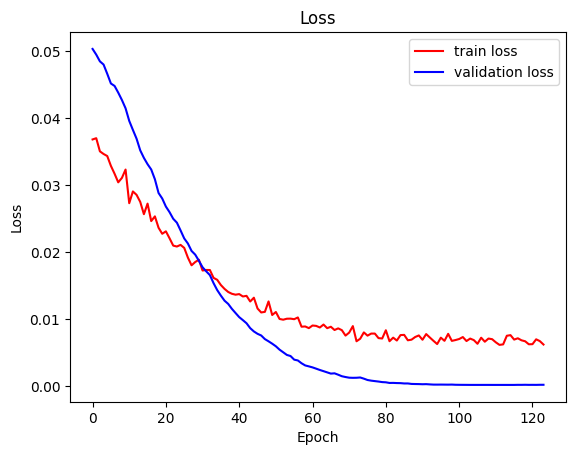

In [16]:
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']
plt.plot(loss_history, color = 'red', label = 'train loss')
plt.plot(val_loss_history, color = 'blue', label = 'validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
# Predict test data and revert the price to the original scale
predicted_price = regressor.predict(X_test)
predicted_price = sc_target.inverse_transform(predicted_price)[:-1]
print('predicted_price shape:',predicted_price.shape)
predicted_price

7/7 [==============================] - 1s 23ms/step
predicted_price shape: (213, 1)


array([[23219.588],
       [22947.816],
       [22553.428],
       [22341.682],
       [22229.639],
       [22146.42 ],
       [21994.957],
       [21469.365],
       [20679.117],
       [20383.611],
       [20679.133],
       [21908.346],
       [23624.568],
       [24203.566],
       [24289.701],
       [25101.986],
       [26241.275],
       [26842.818],
       [27217.08 ],
       [27386.078],
       [27351.525],
       [27322.207],
       [27311.945],
       [27122.361],
       [27090.33 ],
       [26999.37 ],
       [26795.117],
       [27045.697],
       [27497.893],
       [27619.27 ],
       [27779.738],
       [27715.883],
       [27512.209],
       [27485.84 ],
       [27582.447],
       [27549.564],
       [27428.568],
       [27357.764],
       [27423.623],
       [27906.336],
       [28792.195],
       [29309.729],
       [29450.715],
       [29635.424],
       [29729.852],
       [29613.06 ],
       [29367.342],
       [29232.043],
       [29171.568],
       [28657.486],


In [18]:
real_price = dataset_raw_df['target'].iloc[train_index_to:test_index_to].values.reshape(-1,1)[:-1]
print('real_price shape:',real_price.shape)
real_price

real_price shape: (213, 1)


array([[22358.65],
       [22423.38],
       [22405.32],
       [22199.64],
       [21702.16],
       [20356.73],
       [20161.29],
       [20460.09],
       [21981.89],
       [24101.53],
       [24690.97],
       [24274.61],
       [24997.72],
       [27384.12],
       [26905.78],
       [27955.25],
       [27718.1 ],
       [28108.27],
       [27250.91],
       [28287.79],
       [27440.7 ],
       [27470.19],
       [27968.27],
       [27116.04],
       [27259.81],
       [28350.29],
       [28032.83],
       [28469.67],
       [28455.58],
       [28171.86],
       [27802.75],
       [28164.56],
       [28173.02],
       [28014.35],
       [27909.12],
       [27926.9 ],
       [28319.67],
       [29642.3 ],
       [30203.37],
       [29886.18],
       [30383.74],
       [30469.65],
       [30298.12],
       [30304.37],
       [29427.34],
       [30383.04],
       [28782.58],
       [28240.45],
       [27265.56],
       [27815.64],
       [27593.32],
       [27511.41],
       [2829

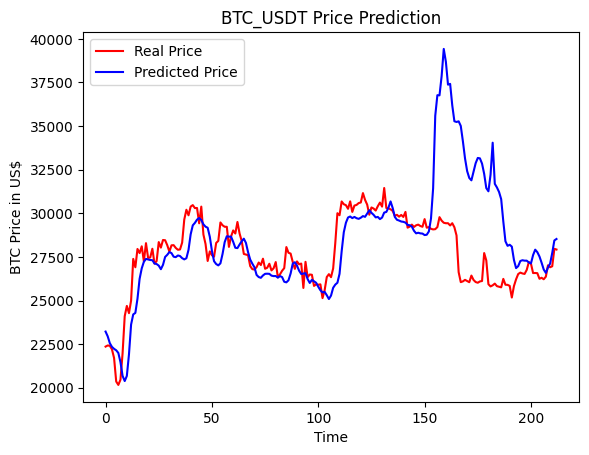

In [19]:
plt.plot(real_price, color = 'red', label = 'Real Price')
plt.plot(predicted_price, color = 'blue', label = 'Predicted Price')
plt.title('BTC_USDT Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price in US$')
plt.legend()
plt.show()